# Setup

In [2]:
# import the packages we need, that are python built ins
import numpy as np
import matplotlib.pyplot as plt
import sys
# we need scipy for the distance functions
import scipy

In [3]:
# load in the haversine function to compute distance appropriately on a sphere
sys.path.append("/Users/dgilford/Dropbox (MIT)/Rutgers/Coastal_Group_SLR/haversine")
from haversine import haversine

# Get the data

In [4]:
# define the data path
datapath="/Users/dgilford/Dropbox (MIT)/Rutgers/Coastal_Group_SLR/"
# import the read code
from vdatum_utilities import read_vdatum_txt

In [5]:
# define the data file to read in
filename='vdatum_input_march_19_result_navd88_to_wgs84.txt'

In [6]:
# load the data
output=read_vdatum_txt(datapath+filename)
lon,lat,elev=output[0],output[1],output[2]
nyx=len(lat)

# remove missing data
lat,lon,elev=lat[~np.isnan(lat)],lon[~np.isnan(lat)],elev[~np.isnan(lat)]

# Visualize the VDATUM data

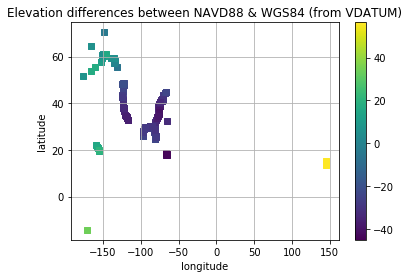

In [7]:
# plot the values with color shading for elevation
fig = plt.figure()
plt.scatter(lon, lat, c=elev, marker='s')
plt.colorbar()
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.grid()
plt.title('Elevation differences between NAVD88 & WGS84 (from VDATUM)')
plt.show()

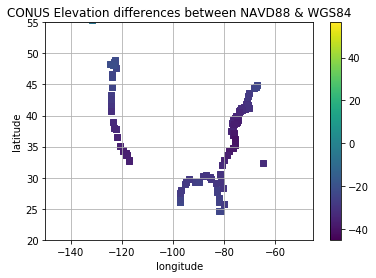

In [8]:
# zoom in on CONUS
conus_lat,conus_lon=[20,55],[-150,-45]
fig = plt.figure()
plt.scatter(lon, lat, c=elev, marker='s')
plt.colorbar()
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.ylim(conus_lat)
plt.xlim(conus_lon)
plt.grid()
plt.title('CONUS Elevation differences between NAVD88 & WGS84')
plt.show()

# Build GP Regressors

In [9]:
# import the GP packages from sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RBF, ConstantKernel

In [10]:
# load the RBF, built by Ian, accounting for different distance functions
customrbf_loc="/Users/dgilford/Dropbox (MIT)/Rutgers/Coastal_Group_SLR/pysurge"
sys.path.append(customrbf_loc)
from pysurge.utilities import CustomDistRBF

In [31]:
# define the prior length scale (and reasonable ranges)
prior_l_hvsn=1000
prior_l_sq=10
prior_r_hvsn=[1e-6,1e6]
prior_r_sq=[1e-4,1e4]
Nrestarts=10

In [12]:
# define the kernel for a baseline RBF Regression (sqeuclidean)
sq_dfx=scipy.spatial.distance.sqeuclidean
gp_kernel_sq = CustomDistRBF(prior_l_sq,prior_r_sq,dist_func=sq_dfx)

# build the GPR object
gpr_sq = GaussianProcessRegressor(kernel=gp_kernel_sq,n_restarts_optimizer=Nrestarts)

# fit the model
X=np.asarray([lat,lon]).transpose()
gpr_sq.fit(X, elev)

/Users/dgilford/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.03776107]), 'nit': 5, 'funcalls': 56}
  " state: %s" % convergence_dict)


GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=CustomDistRBF(length_scale=1),
             n_restarts_optimizer=100, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [22]:
# define the kernel for the updated Haversine distances
gp_kernel_hvsn = ConstantKernel(1.0) * CustomDistRBF(prior_l_hvsn,prior_r_hvsn,dist_func=haversine) + ConstantKernel(1.0)

# build the GPR object
gpr_hvsn = GaussianProcessRegressor(kernel=gp_kernel_hvsn,n_restarts_optimizer=Nrestarts)

# fit the model
X=np.asarray([lat,lon]).transpose()
gpr_hvsn.fit(X, elev)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * CustomDistRBF(length_scale=1) + 1**2,
             n_restarts_optimizer=100, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [23]:
print(gpr_sq.kernel_)
print(gpr_hvsn.kernel_)

CustomDistRBF(length_scale=1.26)
47.7**2 * CustomDistRBF(length_scale=6.2e+04) + 0.0073**2


# Query, and Visualize Results

In [24]:
# create the query grids
lat_r,lon_r=[-80,80],[-180,179]
lat_r[1]=lat_r[1]+1
lon_r[1]=lon_r[1]+1
xy_step=5
latgrid,longrid = np.arange(lat_r[0],lat_r[1],xy_step),np.arange(lon_r[0],lon_r[1],xy_step)
nlat,nlon=len(latgrid),len(longrid)

In [25]:
# create the arrays for the GP means and standard deviations
elev_gpr_sq=np.zeros((nlon,nlat),dtype=float)
elev_std_sq=np.zeros((nlon,nlat),dtype=float)
elev_gpr_hvsn=np.zeros((nlon,nlat),dtype=float)
elev_std_hvsn=np.zeros((nlon,nlat),dtype=float)

# loop over all the points, and fit the model
for x in range(nlon):
    for y in range(nlat):
        # procure the query point
        X_in=np.asarray([latgrid[y],longrid[x]]).reshape(1,-1)
        # query
        elev_gpr_sq[x,y], elev_std_sq[x,y] = gpr_sq.predict(X_in, return_std=True)
        elev_gpr_hvsn[x,y], elev_std_hvsn[x,y] = gpr_hvsn.predict(X_in, return_std=True)

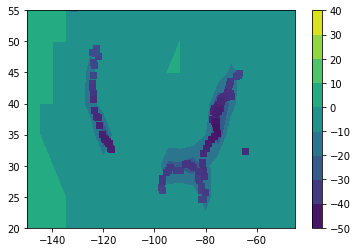

0.008366945234771493

In [26]:
yy,xx=np.meshgrid(latgrid,longrid)
clevels=np.arange(-50,50,10)
# plot for the square euclidean distance
plt.figure()
c1=plt.contourf(xx,yy,elev_gpr_sq,levels=clevels)
plt.scatter(lon, lat, c=elev, marker='s')
#,edgecolors='w'
plt.xlim([-150,-45])
plt.ylim([20,55])
plt.colorbar(c1)
plt.show()

np.min(elev_std_sq)

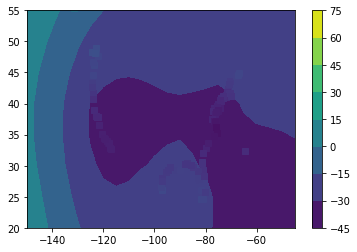

0.6712254280373735

In [27]:
# plot for the square euclidean distance
plt.figure()
c2=plt.contourf(xx,yy,elev_gpr_hvsn)
plt.scatter(lon, lat, c=elev, marker='s')
plt.xlim([-150,-45])
plt.ylim([20,55])
plt.colorbar(c2)
plt.show()

np.min(elev_std_hvsn)

-5.667228254294347e-10
2.3702297661183077e-12


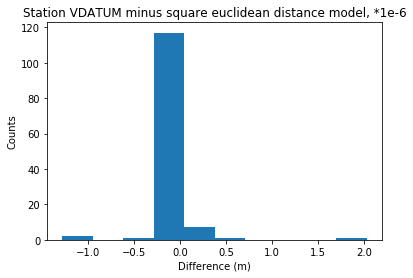

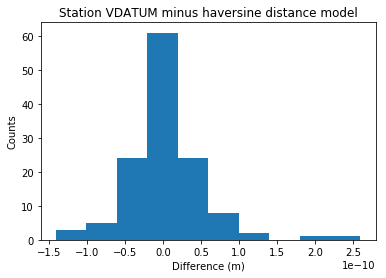

In [28]:
# query at the exact locations of the station to see statistics
stn_gpr_sq,stn_std_sq=gpr_sq.predict(X, return_std=True)
stn_gpr_hvsn,stn_std_hvsn=gpr_hvsn.predict(X, return_std=True)

# output statistics
print(np.mean(elev-stn_gpr_sq))
print(np.mean(elev-stn_gpr_hvsn))

# plot the distributions of the differences
plt.figure()
plt.hist((elev-stn_gpr_sq)*1e6)
plt.title('Station VDATUM minus square euclidean distance model, *1e-6')
plt.xlabel('Difference (m)')
plt.ylabel('Counts')
plt.show()

plt.figure()
plt.hist(elev-stn_gpr_hvsn)
plt.title('Station VDATUM minus haversine distance model')
plt.xlabel('Difference (m)')
plt.ylabel('Counts')
plt.show()

In [29]:
gpr_hvsn.log_marginal_likelihood()

-260.10230894382437

In [30]:
gpr_sq.log_marginal_likelihood()

-21313.92058419302